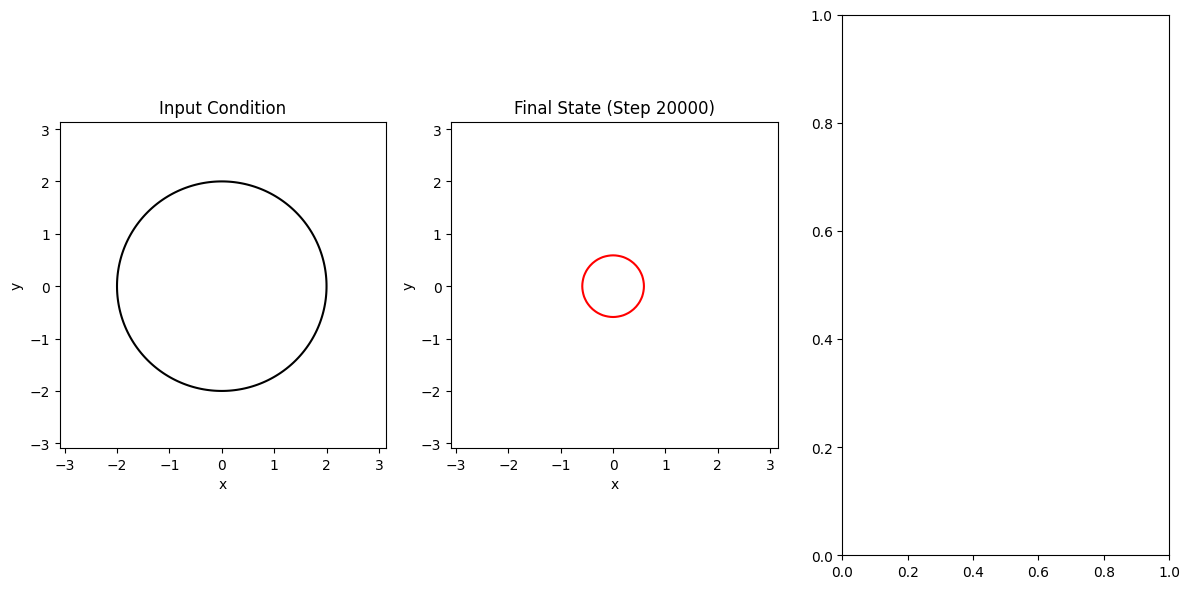

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))




# Define normalization and denormalization functions
def normalize(data):
   mean = jnp.mean(data)
   std = jnp.std(data)
   return (data - mean) / std, mean, std


def denormalize(data, mean, std):
   return data * std + mean


# def FNOBlock2D(modes):
#     def compl_mul2d(input, weights):
#         return jnp.einsum("jixy,ikxy->jkxy", input, weights)


#     def init_fun(rng, input_shape):
#         k1, k2 = random.split(rng)
#         W1 = random.normal(k1, (input_shape[1], input_shape[1], modes, modes))
#         W2 = random.normal(k2, (input_shape[1], input_shape[1], modes, modes))
#         return input_shape, (W1, W2)


#     def apply_fun(params, inputs, **kwargs):
#         W1, W2 = params
#         x_ft = fft2(inputs)
#         out_ft = jnp.zeros_like(x_ft)
#         out_ft = out_ft.at[:, :, : W1.shape[2], : W1.shape[3]].set(compl_mul2d(x_ft[:, :, : W1.shape[2], : W1.shape[3]], W1))
#         out_ft = out_ft.at[:, :, -W2.shape[2] :, : W2.shape[3]].set(compl_mul2d(x_ft[:, :, -W2.shape[2] :, : W2.shape[3]], W2))
#         return ifft2(out_ft)


#     return init_fun, apply_fun




# def Permute(order):
#     def permutation_indices(order):
#         if order == "ijkl->iljk":
#             return (0, 3, 1, 2)
#         elif order == "ijkl->iklj":
#             return (0, 2, 3, 1)
#         else:
#             raise NotImplementedError


#     def init_fun(rng, input_shape):
#         idx = permutation_indices(order)
#         output_shape = tuple([input_shape[i] for i in idx])
#         return output_shape, ()


#     def apply_fun(params, inputs, **kwargs):
#         outputs = jnp.einsum(order, inputs)
#         return outputs


#     return init_fun, apply_fun# Complex Adam optimizer
# @optimizer
# def complex_adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
#     """Construct optimizer triple for complex-valued Adam."""
#     step_size = make_schedule(step_size)


#     def init(x0):
#         m0 = jnp.zeros_like(x0)
#         v0 = jnp.zeros_like(x0)
#         return x0, m0, v0


#     def update(i, g, state):
#         x, m, v = state
#         g = jnp.conj(g)  # Complex conjugate
#         m = (1 - b1) * g + b1 * m  # First moment
#         v = (1 - b2) * jnp.real(jnp.conj(g) * g) + b2 * v  # Second moment
#         mhat = m / (1 - b1 ** (i + 1))  # Bias correction
#         vhat = v / (1 - b2 ** (i + 1))
#         x = x - step_size(i) * mhat / (jnp.sqrt(vhat) + eps)
#         return x, m, v


#     def get_params(state):
#         x, m, v = state
#         return x
def allen_cahn_equation(uk, cahn, dt, pp2, qq2, total_steps=20000):
    for _ in range(total_steps):
        uk = jnp.real(uk)
        # Allen-Cahn equation in Fourier space
        s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))
        v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))
        uk = jfft.ifft2(v_hat)  # Update uk to the next state

    return jnp.real(uk)  # Return only the final state

#     return init, update, get_params
class SPiFOL:
   def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
       self.arch = arch
       self.N = N
       self.lr = lr
       # self.norm_par = norm_par
       self.eps = eps
       self.pp2 = pp2
       self.qq2 = qq2
       self.dt = dt
       self.L = L
       self.h = h
       self.x = x
       self.y = y
       # Initialize the network based on architecture type
       if arch == 'FNO':
           self.N_init, self.N_apply = serial(*fno_layers)
           _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
          
       elif arch == 'MLP':
           self.N_init, self.N_apply = MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
          
       elif arch == 'modified_MLP':
           self.N_init, self.N_apply = modified_MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
       else:
           raise ValueError("Unsupported architecture!")


       self.params = params


       # Optimizer setup
       self.opt_init, self.opt_update, self.get_params = complex_adam(
           jax.example_libraries.optimizers.exponential_decay(
               lr, decay_steps=2000, decay_rate=0.9)
           )
      
       self.opt_state = self.opt_init(self.params)


       # Logging losses
       self.total_loss_log = []
       self.total_energy_loss_log = []


       # Initialize optimizer state
       self.opt_state = self.opt_init(self.params)
       self.itercount = iter(range(10000))


   @partial(jit, static_argnums=(0,))
   def operator_net(self, params, uk):
       if self.arch == 'FNO':
           uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input 
           O = self.N_apply(params, uk)  # Apply the FNO network
           O = jnp.real(O)  # Take the real part of the output
           O = O.reshape(self.N, self.N)  # Reshape output
           return O
       elif self.arch == 'MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)  # Directly apply the network
           O = O.reshape(self.N, self.N)  # Reshape output to match strain components
           # O = O / self.norm_par  # Normalize the output
           return O
       elif self.arch == 'modified_MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)
           O = O.reshape(self.N, self.N)
           return O
       else:
           raise ValueError("Unsupported architecture type!")
      
#    @partial(jit, static_argnums=(0,))
#    def allen_cahn_equation(self,uk, cahn, dt, pp2, qq2, steps=20000):

#         # cahn = self.eps**2  # Cahn number
#         for i in range(steps):
#             uk = jnp.real(uk)
#             # Transforming the solution to the discrete Fourier space
#             s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  # us is the real space
#             v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
#             u_k = jfft.ifft2(v_hat)  # u_k+1 result
            
#             return jnp.real(u_k)  # Ensure the result is real


   def allen_cahn_equation(self, uk, total_steps=20000):
        for _ in range(total_steps):
            cahn = eps**2
            uk = jnp.real(uk)
            # Allen-Cahn equation in Fourier space
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
            v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))
            uk = jfft.ifft2(v_hat)  # Update uk to the next state

        return jnp.real(uk)  # Return only the final state
            


#    @partial(jit, static_argnums=(0,))
#    def laplacian(self, u):
#        return (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
#                jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) - 4 * u) / (self.N ** 2)

#    @partial(jit, static_argnums=(0,))
#    def laplacian(self, u):
#             # factor = (self.N ** 4) / (self.L ** 2)  # Incorporates h^2 / N^2
#             factor = (self.h ** 2) / (self.N ** 2)
#             # factor = 1 / (self.h ** 2)
#             return factor * (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
#                         jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) - 4 * u)


# #    @partial(jit, static_argnums=(0,))
# #    def nonlinear_term(self, u):
# #        return u ** 3 - u
   
  
#    @partial(jit, static_argnums=(0,))
#    def nonlinear_term(self, u):
#     # Compute h^2
#         # h_squared = (self.L / self.N) ** 2
#     # Scaling factor
#         scaling_factor = (self.h ** 2) / (self.eps ** 2)
#     # # Nonlinear term with scaling
#     #     return scaling_factor * (u ** 3 - u)
#         # scaling_factor = 1 / (self.eps ** 2)
#         return scaling_factor * (u ** 3 - u)

#    @partial(jit, static_argnums=(0,))
#    def free_energy_density(self, u):
#         """Compute the bulk free energy density."""
#         return 0.25 * (u ** 2 - 1) ** 2



#    @partial(jit, static_argnums=(0,))
#    def total_energy(self, u):
#        laplacian_u = self.laplacian(u)
#        nonlinear_u = self.nonlinear_term(u)
#     #    bulk_energy = self.free_energy_density(u)
#     #    energy = 0.5 * jnp.sum(laplacian_u ** 2) + (1 / self.eps**2) * jnp.sum(nonlinear_u ** 2)
#        energy = 0.5 * jnp.sum(laplacian_u ** 2) + jnp.sum(nonlinear_u ** 2)
#     #    energy = 0.5 * jnp.sum(laplacian_u ** 2) + jnp.sum(bulk_energy)
#     #    energy = 0.5 * self.eps ** 2 * jnp.sum(laplacian_u ** 2) + jnp.sum(nonlinear_u ** 2)

#        return energy


   @partial(jit, static_argnums=(0,))
   def loss_single(self, params, uk):
       u_pred = self.operator_net(params, uk) # predicted or next value of the initial condition
       u_pred = u_pred.reshape(self.N, self.N)
       uk1 = self.allen_cahn_equation(uk)
      
       # Allen-Cahn equation loss
    #    energy_loss = self.total_energy(u_pred)
       datadriven_loss = jnp.mean((uk1 - u_pred) ** 2)
    #    total_loss = distance_loss + energy_loss
       return datadriven_loss
   


#    @partial(jit, static_argnums=(0,))
#    def laplacian(self, u):
#             factor = 1 / (self.h ** 2)
#             return factor * (
#                 jnp.roll(u, 1, axis=0)
#                 + jnp.roll(u, -1, axis=0)
#                 + jnp.roll(u, 1, axis=1)
#                 + jnp.roll(u, -1, axis=1)
#                 - 4 * u
#         )

#    @partial(jit, static_argnums=(0,))
#    def nonlinear_term(self, u):
#                 scaling_factor = 1 / (self.eps ** 2)
#                 return scaling_factor * (u ** 3 - u)

#    @partial(jit, static_argnums=(0,))
#    def total_energy(self, u):
#             laplacian_u = self.laplacian(u)
#             nonlinear_u = self.nonlinear_term(u)
#             energy = 0.5 * self.eps ** 2 * jnp.sum(laplacian_u ** 2) + jnp.sum(nonlinear_u ** 2)
#             return energy

#    @partial(jit, static_argnums=(0,))
#    def loss_single(self, params, uk, u_gt):
#         u_pred = self.operator_net(params, uk).reshape(self.N, self.N)
#         energy_loss = self.total_energy(u_pred)
#         distance_loss = jnp.mean((u_gt - u_pred) ** 2)
#         alpha, beta = 1.0, 1.0  # Adjust these weights as needed
#         total_loss = alpha * distance_loss + beta * energy_loss
#         return total_loss



   @partial(jit, static_argnums=(0,))
   def step(self, i, opt_state, uk, u_gt):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk)
        return self.opt_update(i, grads, opt_state)


   def train(self, uk, nIter=1000):
        u_gt = self.allen_cahn_equation(uk)  # gt is ground truth
        pbar = trange(nIter)
        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk, u_gt)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            



            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk, u_gt)
                self.total_loss_log.append(loss)
                # self.total_energy_loss_log.append(energy_loss)
                pbar.set_postfix({'Loss': loss})

                #    try:
                #         current_iter = next(self.itercount)
                #    except StopIteration:
                # # Handle the exception, e.g., reset the iterator or log an error
                #         break

# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)


# Plot the figures
# plt.figure(figsize=(10, 6))


# plt.subplot(1, 2, 1)
# plt.title("Initial Condition (u_k)")
# plt.contour(xx, yy, jnp.real(input_condition_i.T), levels=[0], colors="green")


# plt.gca().set_aspect('equal', adjustable='box')
# input_condition, mean, std = normalize(input_condition_i)


# # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)


# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
   # Permute("ijkl->iljk"),
   # FNOBlock2D(32),
   # Gelu,  # activation can be changed here
   # FNOBlock2D(32),
   Gelu,
   # FNOBlock2D(32),
   # Permute("ijkl->iklj"),
   Dense(32),
   Gelu,
   Dense(1),
]


cahn = eps**2
for arch in arch_list:
   # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
    final_state = model.allen_cahn_equation(input_condition)
#    model.train(input_condition, nIter=1)


#    params = model.get_params(model.opt_state)
#    model_prediction = model.operator_net(params, input_condition).reshape(N, N)

# print(f'model prediction = {model_prediction}')
#    model_prediction = denormalize(model_prediction, mean, std)




#    # Plot the figures
#    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
#    contour_levels = 20
#    # input_condition ,mean, std= normalize(input_condition)
#    # axs[0].contourf(xx,yy, jnp.real(input_condition.T),levels=contour_levels)
#    axs[0].contour(x,y, jnp.real(input_condition.T),levels=[0],colors="black")


#    axs[0].set_title('Input Condition')
#    # axs[0].axis('off')
#    axs[0].set_aspect('equal', adjustable='box')
#    # axs[0].set_xlim(-3, 3)
#    # axs[0].set_ylim(-3, 3)
#    axs[0].set_xlabel('x')
#    axs[0].set_ylabel('y')
#    # plt.gca().set_aspect('equal', adjustable='box')


#    # Plot model prediction
#    # axs[1].contour(xx,yy, jnp.real(input_condition_i.T),levels=[0], colors="green")


#    # axs[1].contourf(xx, yy, jnp.real(model_prediction.T), levels=contour_levels)
#    # axs[1].contourf(xx, yy, model_prediction, levels=contour_levels, cmap='viridis')
#    axs[1].contour(x, y, acu, levels=[0], colors="red")
#    axs[1].set_title(f'Model Prediction ({arch})')
#    # axs[1].axis('off')
#    axs[1].set_aspect('equal', adjustable='box')
#    # axs[1].set_xlim(-3, 3)
#    # axs[1].set_ylim(-3, 3)
#    axs[1].set_xlabel('x')
#    axs[1].set_ylabel('y')




# #    # Plot loss
# #    axs[2].plot(model.total_loss_log)
# #    axs[2].set_title('Training Loss')
# #    axs[2].set_xlabel('Iteration')
# #    axs[2].set_ylabel('Loss')




#    plt.tight_layout()
#    plt.show()


# Plot the initial and final states
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Input condition plot
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Final state plot
axs[1].contour(x, y, final_state.T, levels=[0], colors="red")
axs[1].set_title('Final State (Step 20000)')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# np.save("initial_condition.npy", uk)
# np.save("final_output.npy_loop_20000",jnp.real(final_state))




plt.tight_layout()
plt.show()







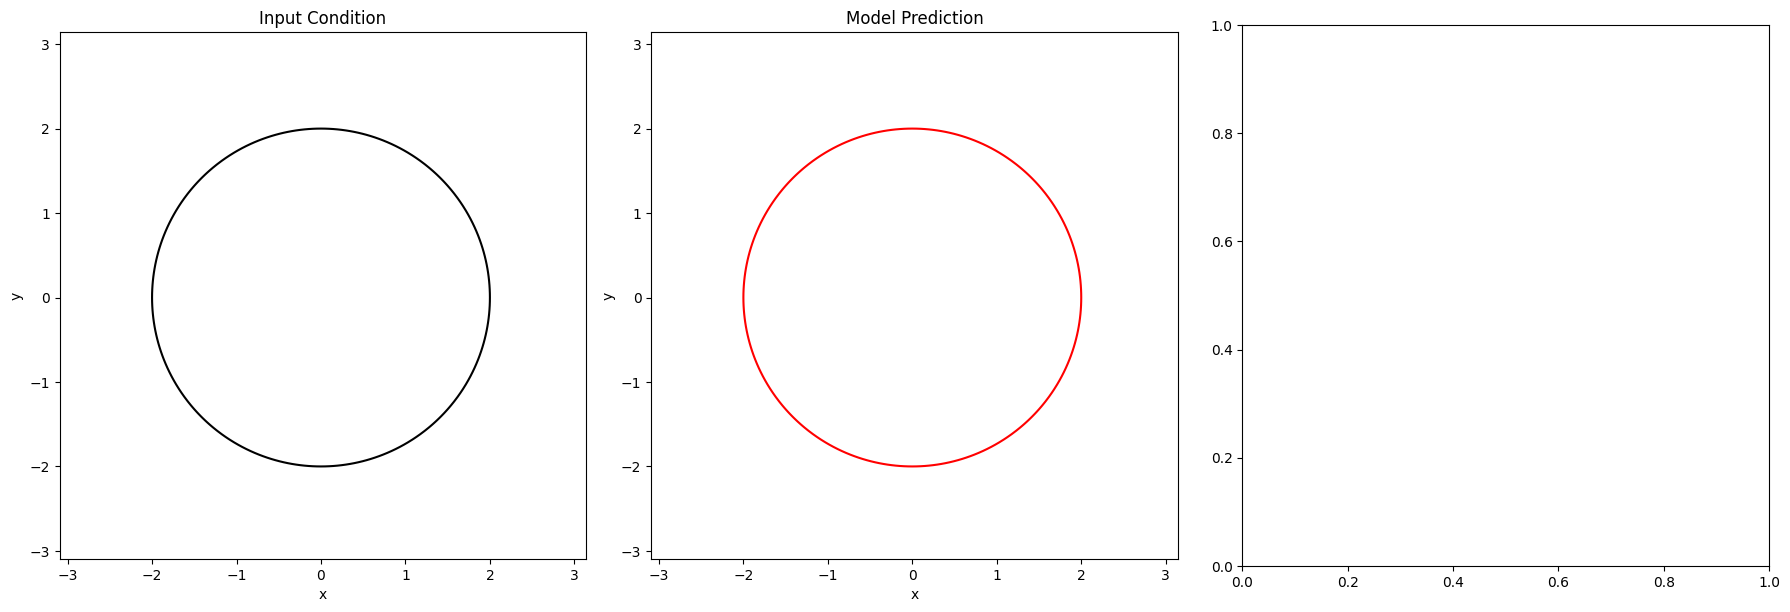

In [ ]:


import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter





















## This is without model 

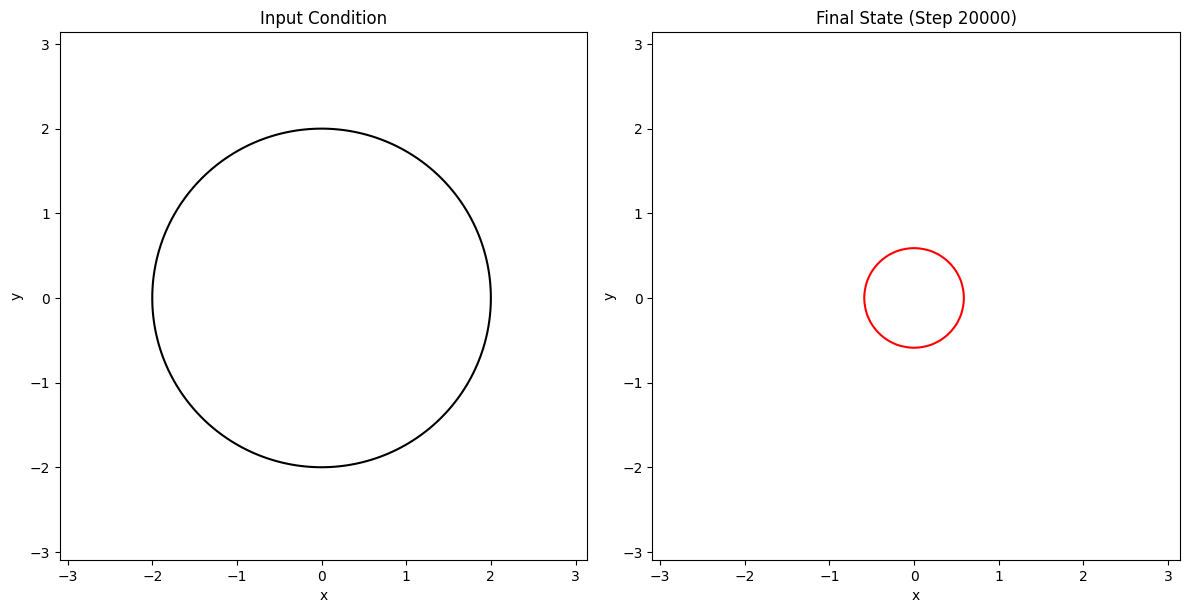

In [1]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter



# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
cahn = eps**2




x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)


# # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)











# def allen_cahn_equation(uk, cahn, dt, pp2, qq2, total_steps=20000):
#     # Create a snapshot mask
#     snapshot_mask = jnp.zeros(total_steps + 1, dtype=bool).at[jnp.array([2000, 4000, 10000, 20000])].set(True)

#     # Initialize the snapshots array
#     snapshots = jnp.zeros((total_steps + 1, *uk.shape), dtype=jnp.float32)
#     snapshots = snapshots.at[0].set(uk)  # Save the initial condition

#     # Time evolution loop
#     for i in range(1, total_steps + 1):
#         uk = jnp.real(uk)
#         # Allen-Cahn equation in Fourier space
#         s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))
#         v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))
#         uk = jfft.ifft2(v_hat)  # Update uk to the next state

#         # Save snapshots based on mask
#         if snapshot_mask[i]:
#             snapshots = snapshots.at[i].set(jnp.real(uk))

#     return snapshots




def allen_cahn_equation(uk, cahn, dt, pp2, qq2, total_steps=20000):
    for _ in range(total_steps):
        uk = jnp.real(uk)
        # Allen-Cahn equation in Fourier space
        s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))
        v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))
        uk = jfft.ifft2(v_hat)  # Update uk to the next state

    return jnp.real(uk)  # Return only the final state


# # Run the Allen-Cahn evolution
# total_steps = 20000
# snapshots = allen_cahn_equation(input_condition, cahn, dt, pp2, qq2, total_steps=total_steps)

# # Plot the results
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Input condition plot
# axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
# axs[0].set_title('Input Condition')
# axs[0].set_aspect('equal', adjustable='box')
# axs[0].set_xlabel('x')
# axs[0].set_ylabel('y')

# # Evolution snapshots
# for step, color in zip([2000, 4000, 10000, 20000], ['red', 'green', 'blue', 'black']):
#     axs[1].contour(x, y, snapshots[step].T, levels=[0], colors=color, label=f"Step {step}")
# axs[1].set_title('Evolution')
# axs[1].legend()
# axs[1].set_aspect('equal', adjustable='box')
# axs[1].set_xlabel('x')
# axs[1].set_ylabel('y')

# # Final condition plot
# axs[2].contour(x, y, snapshots[20000].T, levels=[0], colors="red")
# axs[2].set_title(f'Final Condition (Step 20000)')
# axs[2].set_aspect('equal', adjustable='box')
# axs[2].set_xlabel('x')
# axs[2].set_ylabel('y')

# plt.tight_layout()
# plt.show()


# Run the Allen-Cahn evolution
final_state = allen_cahn_equation(input_condition, cahn, dt, pp2, qq2, total_steps=20000)

# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Input condition plot
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Final state plot
axs[1].contour(x, y, final_state.T, levels=[0], colors="red")
axs[1].set_title('Final State (Step 20000)')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
np.save("final_output.npy_20000",final_state)

plt.tight_layout()
plt.show()

